In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Input, Average
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.models import save_model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall

In [2]:
train_dataset = pd.read_csv('/kaggle/input/fire-detection/train.csv')
val_dataset = pd.read_csv('/kaggle/input/fire-detection/val.csv')
test_dataset = pd.read_csv('/kaggle/input/fire-detection/test.csv')

In [3]:
def create_data_generator(dataframe, directory, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col="Image_Path",
        y_col="Label",
        batch_size=batch_size,
        class_mode='binary',
        target_size=(256, 256),
        shuffle=True
    )
    return generator

In [4]:
batch_size = 32

In [5]:
train_generator = create_data_generator(train_dataset, '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train', batch_size)

Found 1887 validated image filenames belonging to 2 classes.


In [6]:
val_generator = create_data_generator(val_dataset, '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val', batch_size)

Found 402 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="Image_Path". These filename(s) will be ignored.
  warnings.warn(


In [7]:
test_generator = create_data_generator(test_dataset, '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test', batch_size)

Found 410 validated image filenames belonging to 2 classes.


In [8]:
model = models.Sequential()

# Input Layer
model.add(layers.Conv2D(16, (3, 3), padding='same', input_shape=(256, 256, 3)))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.BatchNormalization())

# 256x256x16
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 128x128x32
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 64x64x64
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# 32x32x128
model.add(layers.Conv2D(256, (3, 3), padding='same'))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the convolved data for the Dense layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))  # Slightly reduced dropout

# Dense Layers
model.add(layers.Dense(128))
model.add(layers.LeakyReLU(negative_slope=0.1))
model.add(layers.Dropout(0.3))

# Output Layer
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,783,457 (33.51 MB)

 Trainable params: 8,782,465 (33.50 MB)

 Non-trainable params: 992 (3.88 KB)

In [11]:
history = model.fit(train_generator, epochs=50, shuffle=True, validation_data=val_generator)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731517888.768386      69 service.cc:145] XLA service 0x7ed708018f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731517888.768469      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731517888.768474      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-13 17:11:37.480231: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,128,128]{3,2,1,0}, f32[64,32,3,3]{3,2,

 1/59 ━━━━━━━━━━━━━━━━━━━━ 1:22:30 85s/step - accuracy: 0.6250 - loss: 1.1555 - precision: 0.6786 - recall: 0.8636

I0000 00:00:1731517905.262078      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/59 ━━━━━━━━━━━━━━━━━━━━ 4:50 7s/step - accuracy: 0.6237 - loss: 7.1530 - precision: 0.6962 - recall: 0.7060

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


31/59 ━━━━━━━━━━━━━━━━━━━━ 3:24 7s/step - accuracy: 0.6375 - loss: 6.2112 - precision: 0.7080 - recall: 0.7100

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 597s 9s/step - accuracy: 0.6558 - loss: 4.9892 - precision: 0.7230 - recall: 0.7225 - val_accuracy: 0.4005 - val_loss: 1.6986 - val_precision: 0.5325 - val_recall: 0.1667
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - accuracy: 0.7316 - loss: 1.9973 - precision: 0.7821 - recall: 0.7765 - val_accuracy: 0.4677 - val_loss: 2.4492 - val_precision: 0.9000 - val_recall: 0.1463
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 449s 7s/step - accuracy: 0.7614 - loss: 1.4342 - precision: 0.8136 - recall: 0.8024 - val_accuracy: 0.3905 - val_loss: 6.1973 - val_precision: 1.0000 - val_recall: 0.0041
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 452s 7s/step - accuracy: 0.7426 - loss: 1.3294 - precision: 0.7906 - recall: 0.7956 - val_accuracy: 0.4403 - val_loss: 6.1936 - val_precision: 1.0000 - val_recall: 0.0854
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.7619 - loss: 1.1677 - precision: 0.8020 - recall: 0.8128 - val_accuracy: 0.7040 - val_loss: 0.7311 - val_preci

In [12]:
def plot_training_history1(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Fire Detection Model training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Fire Detection Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

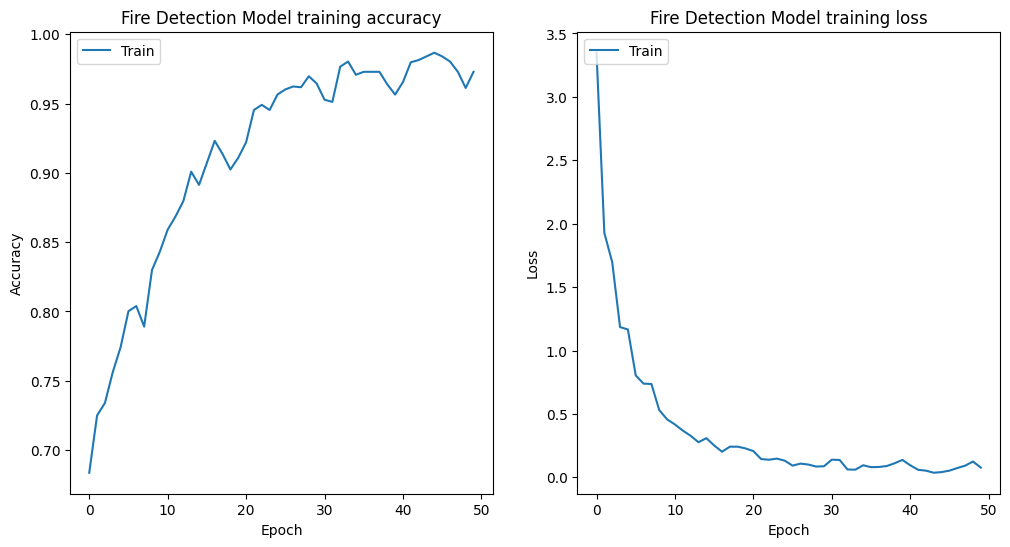

In [13]:
plot_training_history1(history)

In [14]:
model.save('FireDetection.keras')
model.save('FireDetection.h5')

In [15]:
model.evaluate(test_generator)

 8/13 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.8511 - loss: 0.7222 - precision: 0.8579 - recall: 0.9068

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


12/13 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.8473 - loss: 0.7552 - precision: 0.8626 - recall: 0.8936 

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.8465 - loss: 0.7613 - precision: 0.8648 - recall: 0.8888


[0.7981868982315063,
 0.8414633870124817,
 0.8780487775802612,
 0.8605577945709229]